In [19]:
## only needed for plotting in a jupyter notebook.
%matplotlib inline
## Code Block 1

import copy

import numpy as np
from matplotlib import pyplot as plt

from landlab import imshow_grid
from landlab.components import OverlandFlow, FlowAccumulator
from landlab.io import read_esri_ascii

In [20]:
## Code Block 2

basin_flag = "Long"  # 'Square' or Long'
storm_flag = "HigherIntensity"  # 'Base' or'HigherIntensity' or 'LongerDuration'

## If the basin flag matches one of the two select basins,
## below will set the filename which to read the DEM from and
## the outlet link and upstream link to sample discharge values
## from for plotting.

if basin_flag == "Square":
    watershed_dem = "Square_TestBasin.asc"
    ## Reading in the DEM given the filename from above
    (rmg, z) = read_esri_ascii(watershed_dem, name="topographic__elevation")
    outlet_node_to_sample = 300
    outlet_link_to_sample = rmg.links_at_node[outlet_node_to_sample][3]
    upstream_node_to_sample = 28689
    upstream_link_to_sample = rmg.links_at_node[upstream_node_to_sample][3]
    midstream_node_to_sample = 9102
    midstream_link_to_sample = rmg.links_at_node[midstream_node_to_sample][3]
else:
    watershed_dem = "Long_TestBasin.asc"
    ## Reading in the DEM given the filename from above
    (rmg, z) = read_esri_ascii(watershed_dem, name="topographic__elevation")
    outlet_node_to_sample = 150
    outlet_link_to_sample = rmg.links_at_node[outlet_node_to_sample][3]
    upstream_node_to_sample = 33859
    upstream_link_to_sample = rmg.links_at_node[upstream_node_to_sample][3]
    midstream_node_to_sample = 14658
    midstream_link_to_sample = rmg.links_at_node[midstream_node_to_sample][2]

## The Flow Router calculates drainage area, which is helpful for
## calculating equilibrium discharge, which we illustrate later.
fr = FlowAccumulator(rmg)  # Instantiate flow router
fr.run_one_step()  # Drainage area calculated

In [21]:
## Code Block 3

## Set boundary coditions on the grid
rmg.set_watershed_boundary_condition(z)

## instantiate OverlandFlow object
rmg.add_zeros("surface_water__depth", at="node")
of = OverlandFlow(rmg, alpha=0.45, steep_slopes=True)

## Assign storm conditions based on flag in Code Block 2
if storm_flag == "Base":
    starting_precip_mmhr = 5.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 7200.0
elif storm_flag == "HigherIntensity":
    starting_precip_mmhr = 10.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 3600.0
elif storm_flag == "LongerDuration":
    starting_precip_mmhr = 2.5
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 14400.0

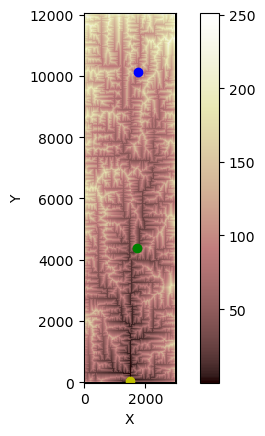

In [22]:
## Code Block 4

plt.figure(1)
imshow_grid(rmg, z)  # plot the DEM
plt.plot(rmg.node_x[outlet_node_to_sample], rmg.node_y[outlet_node_to_sample], "yo")
plt.plot(rmg.node_x[upstream_node_to_sample], rmg.node_y[upstream_node_to_sample], "bo")
plt.plot(
    rmg.node_x[midstream_node_to_sample], rmg.node_y[midstream_node_to_sample], "go"
)

In [23]:
## Code Block 5

elapsed_time = 1.0  # s
model_run_time = 43200.0  # s

## Lists for saving data
discharge_at_outlet = []
discharge_upstream = []
discharge_midstream = []
hydrograph_time = []

## Setting initial fields...
rmg["node"]["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)

In [24]:
## Code Block 6

while elapsed_time < model_run_time:
    # Setting the adaptive time step
    of.dt = of.calc_time_step()

    ## The storm starts when the model starts. While the elapsed time is less
    ## than the storm duration, we add water to the system as rainfall.
    if elapsed_time < (storm_duration):
        of.rainfall_intensity = starting_precip_ms
    else:  # elapsed time exceeds the storm duration, rainfall ceases.
        of.rainfall_intensity = 0.0

    of.run_one_step()  # Generating overland flow based on the deAlmeida solution.

    ## Append time and discharge to their lists to save data and for plotting.
    hydrograph_time.append(elapsed_time)
    q = rmg.at_link["surface_water__discharge"]
    discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * rmg.dx)
    discharge_upstream.append(np.abs(q[upstream_link_to_sample]) * rmg.dx)
    discharge_midstream.append(np.abs(q[midstream_link_to_sample]) * rmg.dx)

    ## output time every now and then so that you know the code
    ## is actually running
    if (elapsed_time % 100) < 2:
        print("elapsed time = ", elapsed_time)

    ## Updating elapsed_time
    elapsed_time += of.dt

elapsed time =  1.0
elapsed time =  2901.21054264
elapsed time =  3101.15446318
elapsed time =  3201.58136814
elapsed time =  3501.94219254
elapsed time =  3601.70079384
elapsed time =  3801.72366697
elapsed time =  3900.30735923
elapsed time =  4201.50319002
elapsed time =  4400.48030069
elapsed time =  4601.72364991
elapsed time =  5200.06823006
elapsed time =  5500.13275891
elapsed time =  5700.75882239
elapsed time =  6001.58859186
elapsed time =  6101.16421435
elapsed time =  6200.67095303
elapsed time =  6300.16857605
elapsed time =  6500.01056358
elapsed time =  6600.56305472
elapsed time =  6701.69785605
elapsed time =  6900.75058329
elapsed time =  7001.59116577
elapsed time =  7300.58573059
elapsed time =  7401.08582521
elapsed time =  7500.47985222
elapsed time =  7800.00899887
elapsed time =  7901.90636554
elapsed time =  8100.94445356
elapsed time =  8400.68481445
elapsed time =  8501.7772352
elapsed time =  8900.29151658
elapsed time =  9001.24373878
elapsed time =  9301.

(0.0, 43192.543581941274, 0.0, 100.0)

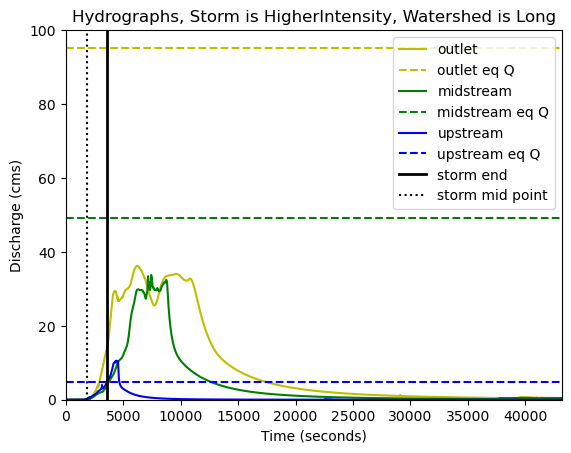

In [25]:
## Code Block 7

## Calculate equilibrium discharge at each point for reference
outlet_eq_q = starting_precip_ms * rmg.at_node["drainage_area"][outlet_node_to_sample]
midstream_eq_q = (
    starting_precip_ms * rmg.at_node["drainage_area"][midstream_node_to_sample]
)
upstream_eq_q = (
    starting_precip_ms * rmg.at_node["drainage_area"][upstream_node_to_sample]
)


## Plotting hydrographs and equilibrium discharge
plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "y-", label="outlet")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [outlet_eq_q, outlet_eq_q],
    "y--",
    label="outlet eq Q",
)
plt.plot(hydrograph_time, discharge_midstream, "g-", label="midstream")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [midstream_eq_q, midstream_eq_q],
    "g--",
    label="midstream eq Q",
)
plt.plot(hydrograph_time, discharge_upstream, "b-", label="upstream")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [upstream_eq_q, upstream_eq_q],
    "b--",
    label="upstream eq Q",
)

## Plot storm end and center of storm for reference
plt.plot(
    [storm_duration, storm_duration], [0, 100], "k-", linewidth=2, label="storm end"
)
plt.plot(
    [storm_duration / 2, storm_duration / 2], [0, 100], "k:", label="storm mid point"
)

plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
title_text = "Hydrographs, Storm is " + storm_flag + ", Watershed is " + basin_flag
plt.title(title_text)
plt.axis([0, np.max(hydrograph_time), 0, 100])